# 1. 패키지 설치 및 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install datasets
# !pip install tensorflow transformers datasets matplotlib scikit-learn
# !pip install numpy pandas tensorflow scikit-learn matplotlib yfinance requests beautifulsoup4 transformers

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=84001f2c097b4ff8b47207b2960258ff49dc0c4b710305e4905ba0f1bdf96229
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import ta

# 2. LSTM 모델 구축

In [7]:
# 주식 데이터 불러오기 (Open, High, Low, Close, Volume)
ticker = 'META'
data = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]

# 열 이름에서 종목명 제거
data.columns = data.columns.get_level_values(0)

# 정규화 수행
scalers = {}
scaled_data = pd.DataFrame(index=data.index, columns=data.columns)
for col in data.columns:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(data[[col]]).flatten()
    scalers[col] = scaler

# 롤링 윈도우 데이터 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])  # Close 값 예측
    return np.array(X), np.array(y)

# 파라미터 설정
time_step = 20
batch_size = 32
epochs = 20

# 입력 피처: Open, High, Low, Close, Volume 사용
X_basic, y_basic = create_rolling_window(scaled_data, time_step)
split = int(len(X_basic) * 0.8)
X_train_basic, X_test_basic = X_basic[:split], X_basic[split:]
y_train_basic, y_test_basic = y_basic[:split], y_basic[split:]

# Bi-LSTM 모델 구축
basic_model = Sequential([
    Input(shape=(time_step, 5)),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

basic_model.compile(optimizer=Adam(), loss=Huber())

# 모델 학습
basic_model.fit(X_train_basic, y_train_basic, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측 수행
y_pred_basic = basic_model.predict(X_test_basic)

# 역정규화 (Close 값만 복원)
y_test_rescaled_basic = scalers['Close'].inverse_transform(y_test_basic.reshape(-1, 1)).flatten()
y_pred_rescaled_basic = scalers['Close'].inverse_transform(y_pred_basic).flatten()

# 성능 평가
rmse_basic = np.sqrt(mean_squared_error(y_test_rescaled_basic, y_pred_rescaled_basic))
mae_basic = mean_absolute_error(y_test_rescaled_basic, y_pred_rescaled_basic)
mape_basic = np.mean(np.abs((y_test_rescaled_basic - y_pred_rescaled_basic) / y_test_rescaled_basic)) * 100

# 방향성 기반 정확도 계산
accuracy_basic = accuracy_score(
    (np.diff(y_test_rescaled_basic) > 0).astype(int),
    (np.diff(y_pred_rescaled_basic) > 0).astype(int)
)

# 결과 출력
print(f"Bi-LSTM Model RMSE: {rmse_basic:.4f}")
print(f"Bi-LSTM Model MAE: {mae_basic:.4f}")
print(f"Bi-LSTM Model MAPE: {mape_basic:.4f}%")
print(f"Bi-LSTM Model Accuracy: {accuracy_basic:.4f}")

[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Bi-LSTM Model RMSE: 33.3057
Bi-LSTM Model MAE: 28.2391
Bi-LSTM Model MAPE: 7.6546%
Bi-LSTM Model Accuracy: 0.5100


#3. 감정분석을 위한 뉴스 가져오기

##3-1. 뉴스 불러오기

In [ ]:
! pip install GoogleNews

In [ ]:
# ! pip install transformers

In [ ]:
# ! pip install torch

In [ ]:
import numpy as np
from GoogleNews import GoogleNews
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from datetime import datetime, timedelta

# 키워드 설정
keywords = ['market', 'stock', 'price', 'trade', 'index', 'profit', 'loss']

# 날짜 설정 (2020년부터 2023년까지 1주 단위)
start_date = datetime(2014, 1, 1)
end_date = datetime(2024, 12, 31)

# FinBERT 감정 분석 모델 로드
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

# 결과 저장 리스트
sentiment_scores = []

# 구글 뉴스 인스턴스
googlenews = GoogleNews(lang='en')

# 1주 단위 수집
current_date = start_date
while current_date <= end_date:
    from_date = current_date.strftime('%m/%d/%Y')
    to_date = (current_date + timedelta(days=6)).strftime('%m/%d/%Y')
    print(f"\n 뉴스 수집 기간: {from_date} ~ {to_date}")

    googlenews.clear()
    googlenews.set_time_range(from_date, to_date)
    googlenews.get_news('META')
    news = googlenews.result()
    top_news = news[:20]

    # 키워드 필터링
    filtered_news = []
    for item in top_news:
        title = item.get('title', '').lower()
        link = item.get('link', '')
        if any(keyword.lower() in title for keyword in keywords):
            filtered_news.append({
                'date': current_date.strftime('%Y-%m-%d'),
                'title': item.get('title', ''),
                'link': link
            })

    if len(filtered_news) > 0:
        # TF-IDF 유사도 기반 중복 제거
        documents = [news['title'] for news in filtered_news]
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(documents)
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        threshold = 0.7
        selected_news = []
        seen_titles = set()

        for i in range(len(filtered_news)):
            max_sim = np.max(cosine_sim[i][cosine_sim[i] < 1]) if len(cosine_sim[i][cosine_sim[i] < 1]) > 0 else 0
            if max_sim < threshold and filtered_news[i]['title'] not in seen_titles:
                selected_news.append(filtered_news[i])
                seen_titles.add(filtered_news[i]['title'])
            if len(selected_news) == 5:
                break

        # 부족 시 추가 보충
        if len(selected_news) < 5:
            additional_news = [news for news in filtered_news if news['title'] not in seen_titles]
            for news in additional_news:
                selected_news.append(news)
                seen_titles.add(news['title'])
                if len(selected_news) == 5:
                    break

        # 감정 분석 수행
        sentiments = []
        titles = []

        for news in selected_news:
            result = sentiment_pipeline(news['title'])[0]
            label = result['label']
            score = result['score']

            # 점수를 0~100으로 변환
            if label == 'positive':
                sentiment_score = 50 + 50 * score
            elif label == 'negative':
                sentiment_score = 50 - 50 * score
            else:
                sentiment_score = 50

            news['sentiment'] = label
            news['score'] = sentiment_score
            sentiments.append(sentiment_score)
            titles.append(news['title'])

            print(f"Title: {news['title']}\n→ Sentiment: {label}, Raw Score: {score:.4f}, Converted: {sentiment_score:.2f}")

        # 평균 감정 점수 + 제목 병합 저장
        sentiment_scores.append({
            'date': current_date.strftime('%Y-%m-%d'),
            'sentiment_score': int(np.mean(sentiments)),  # 평균 후 정수화
            'Title': " | ".join(titles)
        })

        print(f"감정 점수 평균: {np.mean(sentiments):.2f}")

    else:
        # 뉴스 없음: 0점 처리
        sentiment_scores.append({
            'date': current_date.strftime('%Y-%m-%d'),
            'sentiment_score': 50,
            'Title': ''
        })
        print("⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여")

    current_date += timedelta(days=7)

# DataFrame 생성
sentiment_df = pd.DataFrame(sentiment_scores)
sentiment_df['ticker'] = 'META'
sentiment_df['sentiment'] = sentiment_df['sentiment_score'].apply(
    lambda x: 'positive' if x > 60 else 'negative' if x < 40 else 'neutral'
)
sentiment_df['score_weekly'] = sentiment_df['sentiment_score']

# 열 정리 및 저장
final_df = sentiment_df[['date', 'Title', 'ticker', 'sentiment', 'score_weekly']]
final_df.to_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_weekly_sentiment.csv', index=False)

print("\n제목 포함 주차별 감정 CSV 저장 완료 → META_weekly_sentiment.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu



 뉴스 수집 기간: 01/01/2014 ~ 01/07/2014
Title: The B2B Marketer’s Guide to Baidu SEO
→ Sentiment: neutral, Raw Score: 0.9167, Converted: 50.00
감정 점수 평균: 50.00

 뉴스 수집 기간: 01/08/2014 ~ 01/14/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 01/15/2014 ~ 01/21/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 01/22/2014 ~ 01/28/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 01/29/2014 ~ 02/04/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 02/05/2014 ~ 02/11/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 02/12/2014 ~ 02/18/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 02/19/2014 ~ 02/25/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 02/26/2014 ~ 03/04/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 03/05/2014 ~ 03/11/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 03/12/2014 ~ 03/18/2014
Title: Exclusive | Trader kills self in finance world’s latest suicide
→ Sentiment: neutral, Raw Score: 0.4926, Converted: 50.00
감정 점수 평균: 50.00

 뉴스 수집 기간: 03/19/2014 ~ 03/25/2014
⚠️ 필터링된 뉴스 없음 → 중립 점수 50 부여

 뉴스 수집 기간: 03/26/2014 ~

##3-2.뉴스 매일매일로 늘리기

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# 1. 주차별 감정 점수 불러오기
weekly_df = pd.read_csv("/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_weekly_sentiment.csv")
weekly_df['date'] = pd.to_datetime(weekly_df['date'])

# 2. 주 시작일을 월요일로 보정
weekly_df['week_start'] = weekly_df['date'].apply(lambda x: x - timedelta(days=x.weekday()))

# 뉴스 제목 제거
weekly_df = weekly_df[['week_start', 'ticker', 'sentiment', 'score_weekly']]

# 3. 전체 일자 생성
daily_dates = pd.date_range(start='2014-01-01', end='2024-12-31', freq='D')
daily_df = pd.DataFrame({'date': daily_dates})
daily_df['week_start'] = daily_df['date'].apply(lambda x: x - timedelta(days=x.weekday()))

# 4. 병합
merged_df = pd.merge(daily_df, weekly_df, on='week_start', how='left')

# 5. 결과 정리
final_df = merged_df[['date', 'ticker', 'sentiment', 'score_weekly']]

# 6. 저장
final_df.to_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_daily_sentiment.csv', index=False)
print("매일 날짜별 감정 점수 저장 완료 → META_daily_sentiment.csv")

매일 날짜별 감정 점수 저장 완료 → META_daily_sentiment.csv


## 3-3. 뉴스 데이터 합치기(매일매일 + 평균값)

In [ ]:
# 1. 뉴스 감정 점수 (news_scored.csv) 불러오기
news_df = pd.read_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/meta_daily_sentiment_avg.csv')
news_df['date'] = pd.to_datetime(news_df['date'])

# 2. 날짜별 평균 점수 계산
# news_daily = news_df.groupby('date')['score'].mean().reset_index()
# news_daily.rename(columns={'score': 'score_news'}, inplace=True)

# 필요한 컬럼만 선택
news_daily = news_df[['date', 'sentiment_mean']]

# 3. AAPL 일별 감정 점수 (AAPL_daily_sentiment.csv) 불러오기
sentiment_df = pd.read_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_daily_sentiment.csv')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# 4. 필요한 컬럼만 선택
sentiment_daily = sentiment_df[['date', 'score_weekly']]

# 5. 날짜 기준으로 병합
merged_df = pd.merge(news_daily, sentiment_daily, on='date', how='inner').sort_values(by='date')

# # 컬럼명 변경
# merged_df.rename(columns={'date': 'Date'}, inplace=True)

# # 변경된 내용 확인
# print(merged_df.columns)

# 변경된 파일 저장 (선택 사항)
merged_df.to_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_merged_sentiment.csv', index=False)
print("뉴스 + 주간 감정 점수 병합 완료 → META_merged_sentiment.csv")

뉴스 + 주간 감정 점수 병합 완료 → META_merged_sentiment.csv


#4. 감정분석(BERT사용) / 학습 및 모델 적용

감정 분석 모델 설정

HuggingFace에서 사전 학습된 금융 BERT 모델 사용

감정 점수 추가 후 LSTM 모델 재학습

In [ ]:
# ! pip install --upgrade transformers

In [8]:
# 주가 데이터
ticker = 'META'
data = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]
data = data.reset_index()  # 인덱스를 Date 컬럼으로

# 열 이름에서 종목명 제거
data.columns = data.columns.get_level_values(0)

# 감정 점수 불러오기
sentiment = pd.read_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/META_merged_sentiment.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment = sentiment.rename(columns={'date': 'Date'})

# 병합
merged = pd.merge(data, sentiment, on='Date', how='left')

# 결측치 보간 (경고 해결 버전)
merged[['score_news', 'score_weekly']] = merged[['sentiment_mean', 'score_weekly']].ffill().bfill()

# ============기술적 지표 및 계산 통합============
merged_ta = merged.copy()
close_series = merged_ta['Close']

# RSI
merged_ta['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()

# MACD_diff = MACD - Signal
merged_ta['MACD_diff'] = ta.trend.MACD(close=close_series).macd_diff()

# BBP = Bollinger Percent Band
merged_ta['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()

# VIX (공포지수)
vix = yf.download('^VIX', start='2014-01-01', end='2024-12-31')[['Close']]
vix.columns = vix.columns.get_level_values(0)
vix = vix.rename(columns={'Close': 'VIX'})
vix = vix.reset_index()
vix = vix.rename(columns={'date': 'Date'})
vix['Date'] = pd.to_datetime(vix['Date'])

# 병합 및 결측치 처리
merged_ta = pd.merge(merged_ta, vix[['Date', 'VIX']], on='Date', how='left')
merged_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']] = merged_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']].ffill().bfill()
# ===========================================
# 모든 피처 정규화 (merged_ta 기준으로)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_mean', 'score_weekly',
            'RSI', 'MACD_diff', 'BBP', 'VIX']

scaled_data = pd.DataFrame(index=merged_ta.index)
scalers = {}

for col in features:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(merged_ta[[col]]).flatten()
    scalers[col] = scaler

Input(shape=(time_step, len(features)))


# 롤링 윈도우 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])
    return np.array(X), np.array(y)

# 파라미터
time_step = 20
batch_size = 32
epochs = 20

# 데이터 생성
X_plus, y_plus = create_rolling_window(scaled_data, time_step)
split = int(len(X_plus) * 0.8)
X_train_plus, X_test_plus = X_plus[:split], X_plus[split:]
y_train_plus, y_test_plus = y_plus[:split], y_plus[split:]

# Bi-LSTM 모델 정의
plus_model = Sequential([
    Input(shape=(time_step, len(features))),  # 13개 피처
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

# 학습
plus_model.compile(optimizer=Adam(), loss=Huber())
plus_model.fit(X_train_plus, y_train_plus, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측
y_pred_plus = plus_model.predict(X_test_plus)

# 역정규화
y_test_rescaled_plus = scalers['Close'].inverse_transform(y_test_plus.reshape(-1, 1)).flatten()
y_pred_rescaled_plus = scalers['Close'].inverse_transform(y_pred_plus).flatten()

# 성능 평가
rmse_plus = np.sqrt(mean_squared_error(y_test_rescaled_plus, y_pred_rescaled_plus))
mae_plus = mean_absolute_error(y_test_rescaled_plus, y_pred_rescaled_plus)
mape_plus = np.mean(np.abs((y_test_rescaled_plus - y_pred_rescaled_plus) / y_test_rescaled_plus)) * 100
accuracy_plus = accuracy_score(
    (np.diff(y_test_rescaled_plus) > 0).astype(int),
    (np.diff(y_pred_rescaled_plus) > 0).astype(int)
)

# 결과 출력
print(f"\nPlus Model RMSE: {rmse_plus:.4f}")
print(f"Plus Model MAE: {mae_plus:.4f}")
print(f"Plus Model MAPE: {mape_plus:.4f}%")
print(f"Plus Model Accuracy: {accuracy_plus:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Plus Model RMSE: 24.1516
Plus Model MAE: 18.2516
Plus Model MAPE: 4.7424%
Plus Model Accuracy: 0.5118


#5. 멀티모달 결과 그래프

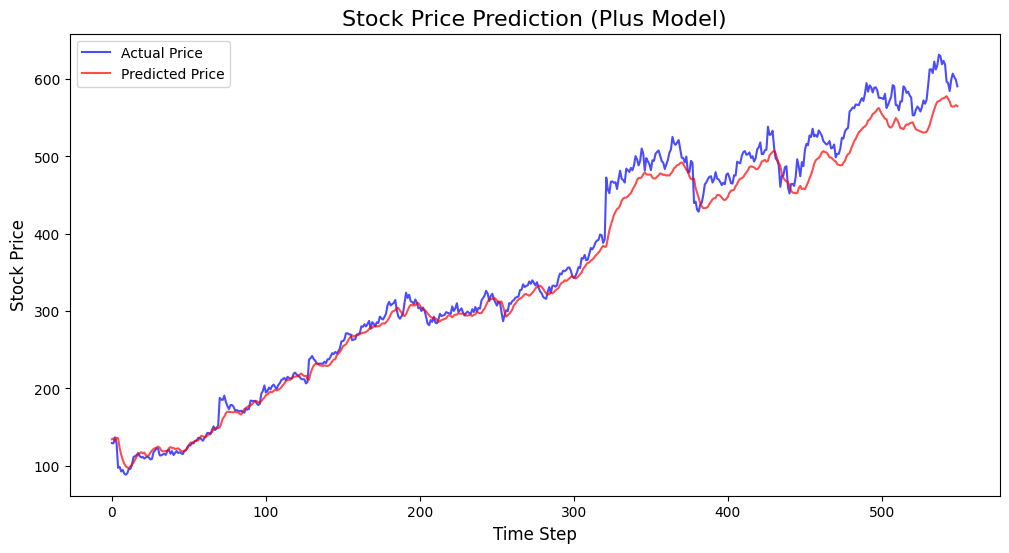

In [ ]:
import matplotlib.pyplot as plt

# 예측 그래프 그리기
plt.figure(figsize=(12, 6))

# 실제 주가 그래프
plt.plot(y_test_rescaled_plus, label='Actual Price', color='blue', alpha=0.7)

# 예측 주가 그래프
plt.plot(y_pred_rescaled_plus, label='Predicted Price', color='red', alpha=0.7)

# 그래프 설정
plt.title('Stock Price Prediction (Plus Model)', fontsize=16)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()

# 그래프 표시
plt.show()

# 단일모달 VS 멀티모달 성능평가

In [9]:
# 성능 지표 저장
results = {
    'RMSE': [rmse_basic, rmse_plus],
    'MAE': [mae_basic, mae_plus],
    'MAPE': [mape_basic, mape_plus],
    'Accuracy': [accuracy_basic, accuracy_plus]
}
results_df = pd.DataFrame(results, index=['Basic Model', 'Plus Model'])

# 날짜 인덱스 생성 및 할당
date_index = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data.index = date_index[:len(scaled_data)]

# 날짜 인덱스 설정
test_dates = scaled_data.index[-len(y_test_rescaled_plus):]

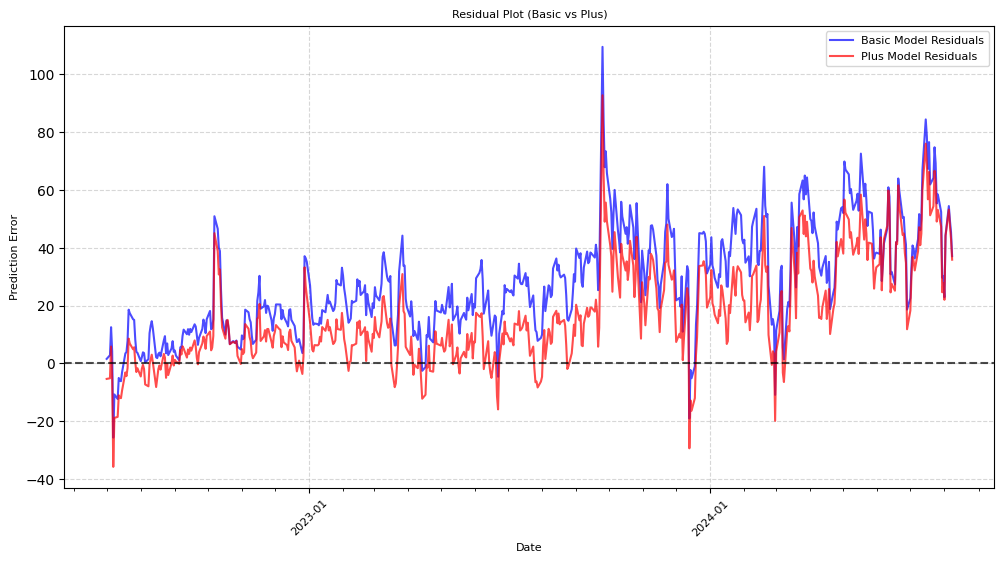

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===== 잔차 그래프 =====
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_rescaled_plus - y_pred_rescaled_basic,
         label='Basic Model Residuals', color='blue', alpha=0.7)
plt.plot(test_dates, y_test_rescaled_plus - y_pred_rescaled_plus,
         label='Plus Model Residuals', color='red', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, fontname='Times New Roman', fontsize=8)

plt.title('Residual Plot (Basic vs Plus)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Prediction Error', fontsize=8, fontname='Times New Roman')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Figure size 1000x600 with 0 Axes>

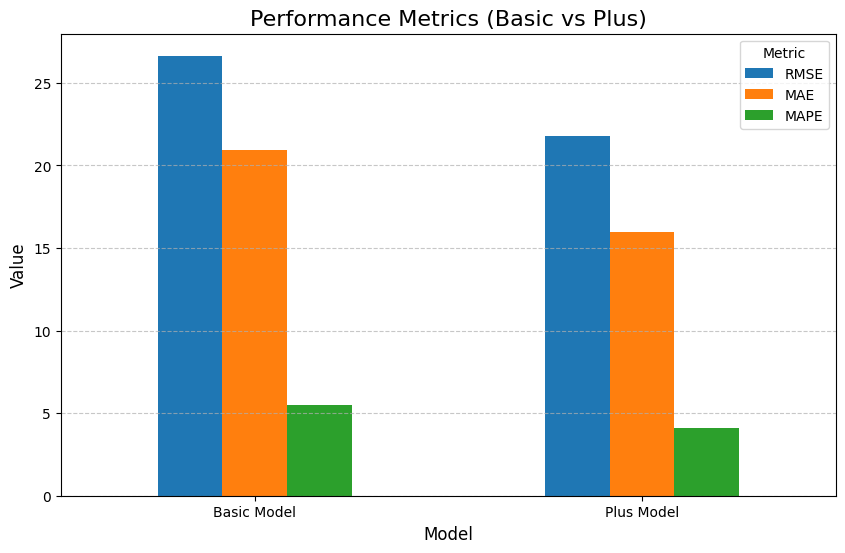

In [ ]:
# plt.figure(figsize=(10, 6))

# # 성능 지표 막대 그래프
# results_df[['RMSE', 'MAE', 'MAPE']].plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# # 그래프 설정
# plt.title('Performance Metrics (Basic vs Plus)', fontsize=16)
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('Value', fontsize=12)
# plt.xticks(rotation=0)

# # 그리드 추가
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.legend(title='Metric')

# plt.show()

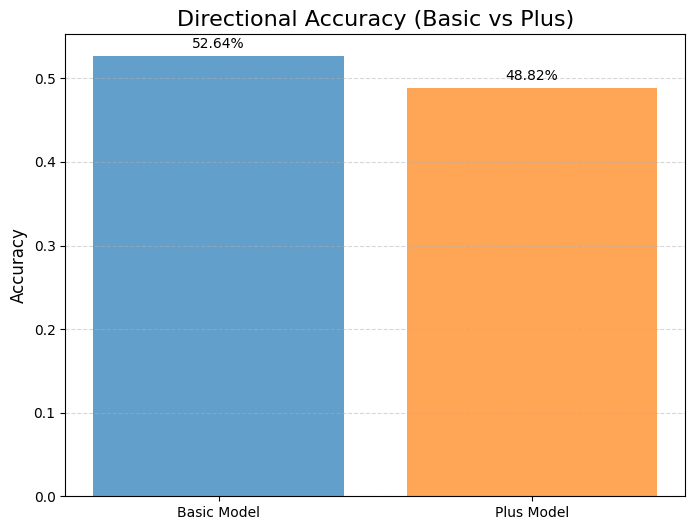

In [ ]:
# plt.figure(figsize=(8, 6))

# # 방향성 정확도 시각화
# plt.bar(['Basic Model', 'Plus Model'], results_df['Accuracy'],
#         color=['#1f77b4', '#ff7f0e'], alpha=0.7)

# # 그래프 설정
# plt.title('Directional Accuracy (Basic vs Plus)', fontsize=16)
# plt.ylabel('Accuracy', fontsize=12)

# # 수치 출력
# for i, acc in enumerate(results_df['Accuracy']):
#     plt.text(i, acc + 0.01, f'{acc:.2%}', ha='center', fontsize=10)

# # 그리드 추가
# plt.grid(axis='y', linestyle='--', alpha=0.5)

# plt.show()

<ipython-input-23-6b884119e6c6>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)



### Evaluation Comparison ###
                      Model       RMSE        MAE      MAPE  Accuracy
0             Basic (Close)  33.305750  28.239073  7.654589  0.510018
1  Plus (OHLCV + Sentiment)  24.151623  18.251568  4.742443  0.511840


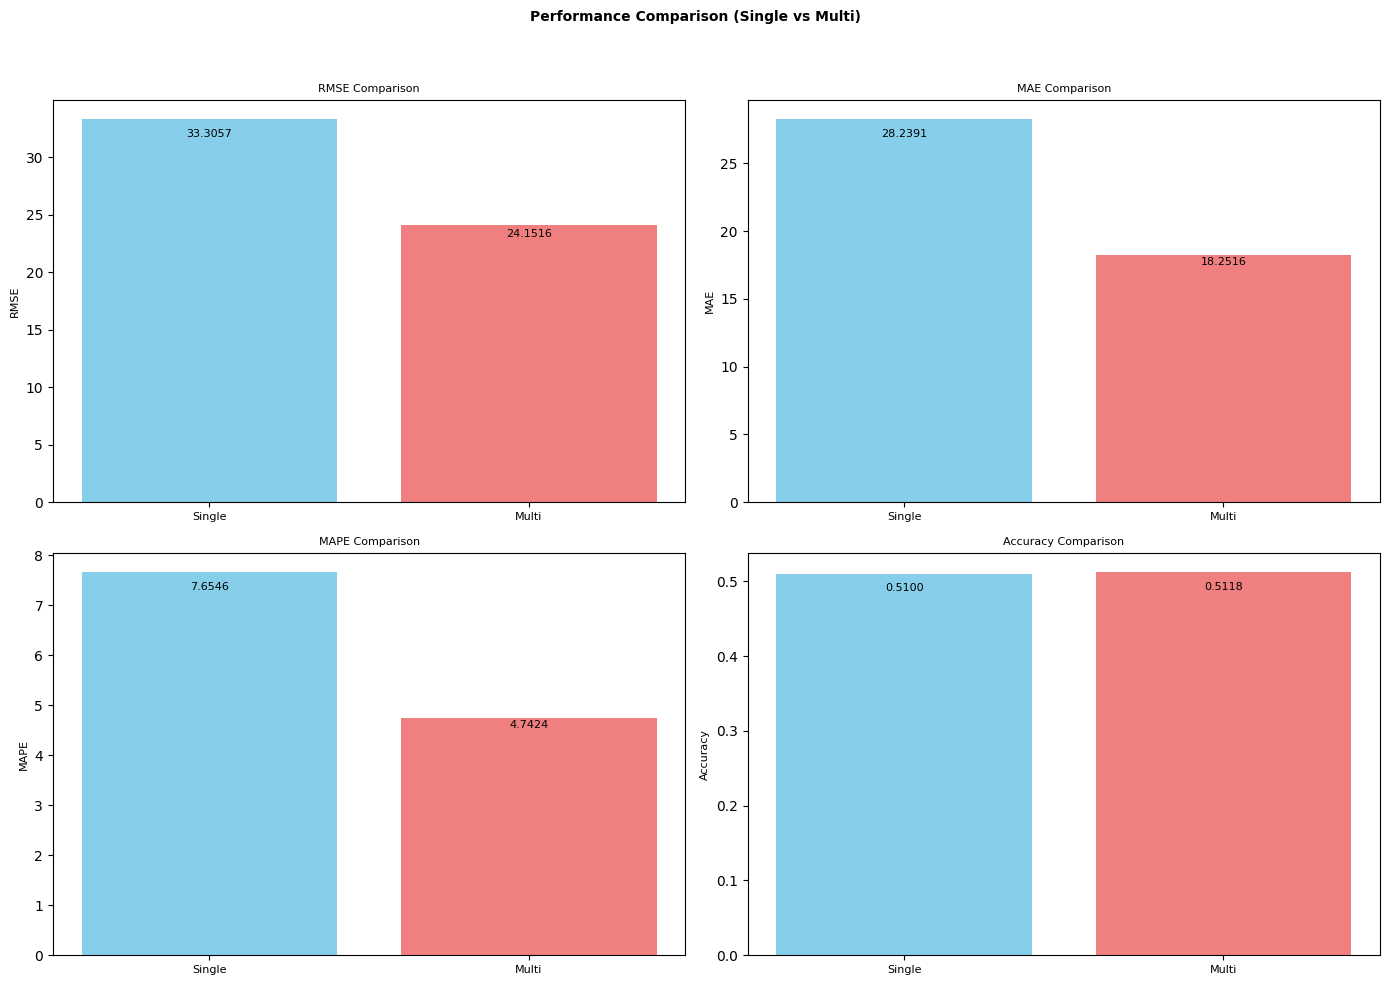

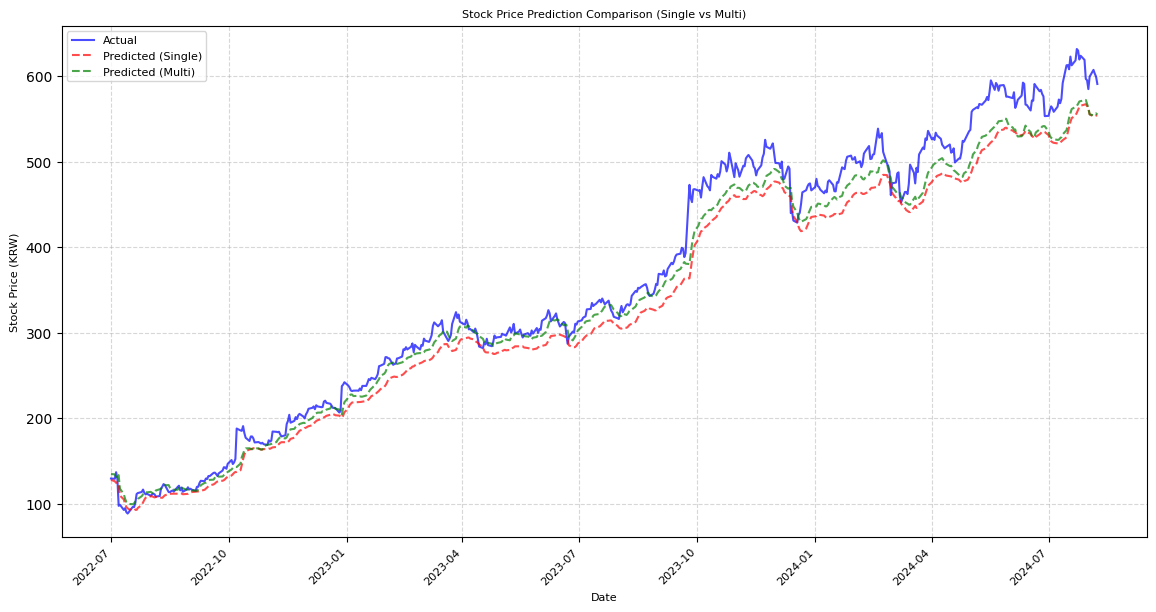

<ipython-input-23-6b884119e6c6>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-23-6b884119e6c6>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)


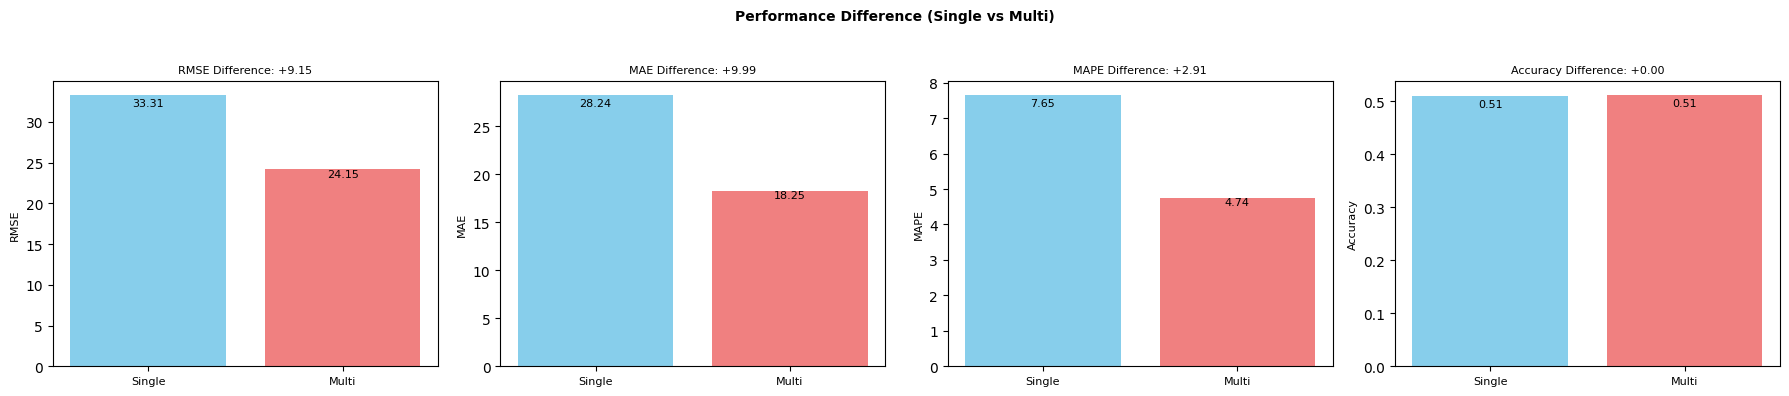

In [23]:
# ===== 성능 비교 표 출력 =====
results = pd.DataFrame({
    'Model': ['Basic (Close)', 'Plus (OHLCV + Sentiment)'],
    'RMSE': [rmse_basic, rmse_plus],
    'MAE': [mae_basic, mae_plus],
    'MAPE': [mape_basic, mape_plus],
    'Accuracy': [accuracy_basic, accuracy_plus]
})
print("\n### Evaluation Comparison ###")
print(results)

# ===== 성능 비교 바 그래프 =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['RMSE', 'MAE', 'MAPE', 'Accuracy']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(['Single', 'Multi'],
           [results.loc[0, metric], results.loc[1, metric]], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=8, fontname='Times New Roman')
    ax.set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
    for j, value in enumerate([results.loc[0, metric], results.loc[1, metric]]):
        ax.text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Comparison (Single vs Multi)', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ===== 실제 vs 예측 주가 그래프 =====
date_index = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data.index = date_index[:len(scaled_data)]
predicted_index = scaled_data.index[-len(y_test_rescaled_plus):]

plt.figure(figsize=(14, 7))
plt.plot(predicted_index, y_test_rescaled_plus, label='Actual', color='blue', alpha=0.7)
plt.plot(predicted_index, y_pred_rescaled_basic, label='Predicted (Single)', color='red', linestyle='--', alpha=0.7)
plt.plot(predicted_index, y_pred_rescaled_plus, label='Predicted (Multi)', color='green', linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right', fontname='Times New Roman', fontsize=8)

plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.title('Stock Price Prediction Comparison (Single vs Multi)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Stock Price (KRW)', fontsize=8, fontname='Times New Roman')
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.15)
plt.show()

# ===== 성능 차이 강조 그래프 =====
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
for i, metric in enumerate(metrics):
    if metric == 'Accuracy':
        diff = results.loc[1, metric] - results.loc[0, metric]
    else:
        diff = results.loc[0, metric] - results.loc[1, metric]
    sign = '+' if diff > 0 else '-'
    display_diff = f'{sign}{abs(diff):.2f}'

    ax[i].bar(['Single', 'Multi'],
              [results.loc[0, metric], results.loc[1, metric]],
              color=colors)
    ax[i].set_title(f'{metric} Difference: {display_diff}', fontsize=8, fontname='Times New Roman')
    ax[i].set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
    for j, value in enumerate([results.loc[0, metric], results.loc[1, metric]]):
        ax[i].text(j, value * 0.95, f'{value:.2f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Difference (Single vs Multi)', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# feature importance

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Feature Importance (Permutation 방식):
Open           : 0.010193
High           : 0.005759
Low            : 0.011391
Close          : 0.012378
Volume         : 0.000176
score_news     : -0.000007
score_weekly   : -0.000012
RSI            : 0.000088
MACD_diff      : 0.000132
BBP            : 0.000106
VIX            : -0.000006


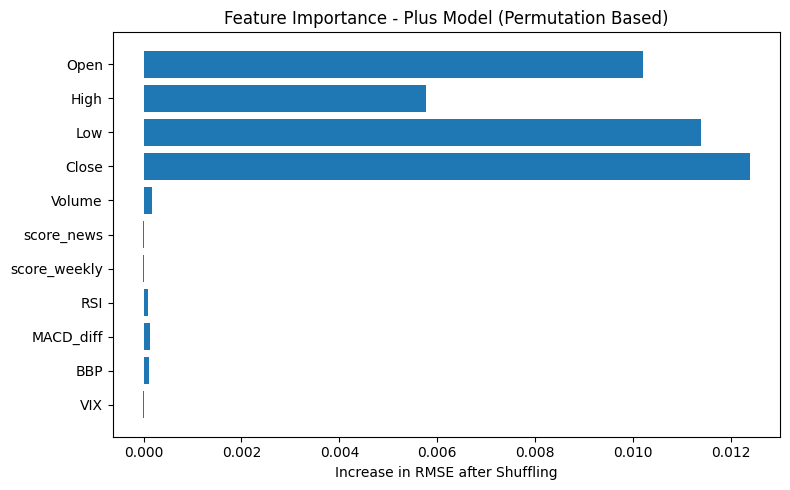

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 중요도 계산 함수
def permutation_importance_lstm(model, X_val, y_val, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'score_news', 'score_weekly',
            'RSI', 'MACD_diff', 'BBP', 'VIX']

    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])  # i번째 feature만 섞음
        permuted_score = metric(y_val, model.predict(X_permuted))
        importances.append(permuted_score - baseline)

    return dict(zip(feature_names, importances))

# 중요도 계산
importances = permutation_importance_lstm(plus_model, X_test_plus, y_test_plus)

# 결과 출력
print("\nFeature Importance (Permutation 방식):")
for k, v in importances.items():
    print(f"{k:15s}: {v:.6f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(list(importances.keys()), list(importances.values()))
plt.xlabel("Increase in RMSE after Shuffling")
plt.title("Feature Importance - Plus Model (Permutation Based)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7682/7682 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7694/7694 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7700/7700 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step


<Figure size 640x480 with 0 Axes>

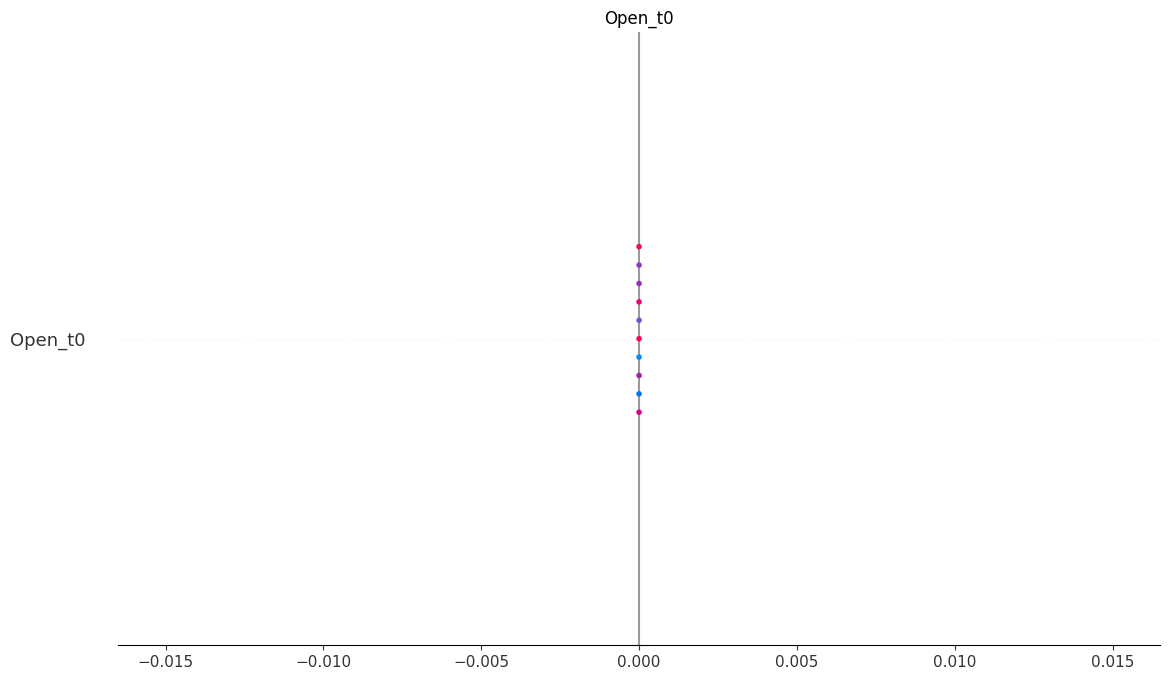

In [ ]:
import shap
import numpy as np

# flatten: LSTM 입력을 (samples, time_step * features) 형태로 변환
X_train_flat = X_train_plus[:100].reshape(100, -1)
X_test_flat = X_test_plus[:10].reshape(10, -1)

# 예측 함수 정의: 다시 (samples, time_step, features)로 reshape해서 모델에 넣기
def model_predict(x):
    x_reshaped = x.reshape((-1, 20, 11))  # time_step=20, features=11
    return plus_model.predict(x_reshaped)

# KernelExplainer 생성
explainer = shap.KernelExplainer(model_predict, X_train_flat)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test_flat)

# feature 이름 생성: Open_t0, High_t0, ..., score_weekly_t19
base_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'score_news', 'score_weekly',
            'RSI', 'MACD_diff', 'BBP', 'VIX']
feature_names = [f"{feat}_t{t}" for t in range(20) for feat in base_features]

# summary_plot 시각화
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names)

In [ ]:
shap_array = np.array(shap_values)  # shap_values: List → ndarray
mean_abs_shape = np.mean(np.abs(shap_array), axis=1)

print("평균 절댓값 SHAP:", mean_abs_shape)

평균 절댓값 SHAP: [[0.00063189]
 [0.00062374]
 [0.00060276]
 [0.00062137]
 [0.00060324]
 [0.00048452]
 [0.00042804]
 [0.00038248]
 [0.00035295]
 [0.00033847]]


In [ ]:
print("feature_names shape:", np.array(feature_names).shape)
print("mean_shap shape:", mean_abs_shape.shape)

feature_names shape: (220,)
mean_shap shape: (10, 1)


In [ ]:
print("shap_array shape:", shap_array.shape)

shap_array shape: (10, 220, 1)


In [ ]:
# 마지막 차원 제거 (3D → 2D)
# shap_array = shap_array.squeeze(axis=2)  # or
shap_array = shap_array.reshape(10, 220)

# 각 feature별 평균 SHAP 계산
mean_shap = np.mean(np.abs(shap_array), axis=0)  # shape: (220,)

# DataFrame 생성
top_features = pd.DataFrame({
    "Feature": feature_names,         # shape: (220,)
    "Mean_Abs_SHAP": mean_shap        # shape: (220,)
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

top_features.head(30)

,Feature,Mean_Abs_SHAP
13,Low_t1,0.008851
199,High_t18,0.008653
2,Low_t0,0.008651
189,Low_t17,0.007744
211,Low_t19,0.007250
200,Low_t18,0.006665
188,High_t17,0.006646
178,Low_t16,0.006467
210,High_t19,0.005199
167,Low_t15,0.004752


#ebay

In [27]:
# 주식 데이터 불러오기 (Open, High, Low, Close, Volume)
ticker = 'EBAY'
data = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = data.columns.get_level_values(0)

# 정규화 수행
scalers_ebay = {}
scaled_data_ebay = pd.DataFrame(index=data.index, columns=data.columns)
for col in data.columns:
    scaler = MinMaxScaler()
    scaled_data_ebay[col] = scaler.fit_transform(data[[col]]).flatten()
    scalers_ebay[col] = scaler

# 롤링 윈도우 데이터 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])
    return np.array(X), np.array(y)

# 파라미터 설정
time_step = 20
batch_size = 32
epochs = 20

# 입력 피처: Open, High, Low, Close, Volume 사용
X_ebay_basic, y_ebay_basic = create_rolling_window(scaled_data_ebay, time_step)
split = int(len(X_ebay_basic) * 0.8)
X_train_ebay_basic, X_test_ebay_basic = X_ebay_basic[:split], X_ebay_basic[split:]
y_train_ebay_basic, y_test_ebay_basic = y_ebay_basic[:split], y_ebay_basic[split:]

# Bi-LSTM 모델 구축
ebay_basic_model = Sequential([
    Input(shape=(time_step, 5)),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

ebay_basic_model.compile(optimizer=Adam(), loss=Huber())

# 모델 학습
ebay_basic_model.fit(X_train_ebay_basic, y_train_ebay_basic, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측 수행
y_pred_ebay_basic = ebay_basic_model.predict(X_test_ebay_basic)

# 역정규화
y_test_rescaled_ebay_basic = scalers_ebay['Close'].inverse_transform(y_test_ebay_basic.reshape(-1, 1)).flatten()
y_pred_rescaled_ebay_basic = scalers_ebay['Close'].inverse_transform(y_pred_ebay_basic).flatten()

# 성능 평가
rmse_ebay_basic = np.sqrt(mean_squared_error(y_test_rescaled_ebay_basic, y_pred_rescaled_ebay_basic))
mae_ebay_basic = mean_absolute_error(y_test_rescaled_ebay_basic, y_pred_rescaled_ebay_basic)
mape_ebay_basic = np.mean(np.abs((y_test_rescaled_ebay_basic - y_pred_rescaled_ebay_basic) / y_test_rescaled_ebay_basic)) * 100

# 방향성 기반 정확도 계산
accuracy_ebay_basic = accuracy_score(
    (np.diff(y_test_rescaled_ebay_basic) > 0).astype(int),
    (np.diff(y_pred_rescaled_ebay_basic) > 0).astype(int)
)

# 결과 출력
print(f"EBAY Bi-LSTM Model RMSE: {rmse_ebay_basic:.4f}")
print(f"EBAY Bi-LSTM Model MAE: {mae_ebay_basic:.4f}")
print(f"EBAY Bi-LSTM Model MAPE: {mape_ebay_basic:.4f}%")
print(f"EBAY Bi-LSTM Model Accuracy: {accuracy_ebay_basic:.4f}")

[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
EBAY Bi-LSTM Model RMSE: 1.2736
EBAY Bi-LSTM Model MAE: 0.9696
EBAY Bi-LSTM Model MAPE: 2.0911%
EBAY Bi-LSTM Model Accuracy: 0.4845


In [32]:
# 주가 데이터
ticker = 'EBAY'
data_ebay = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]
data_ebay = data_ebay.reset_index()

# 열 이름 정리
data_ebay.columns = data_ebay.columns.get_level_values(0)

# 감정 점수 불러오기
sentiment_ebay = pd.read_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/EBAY_merged_sentiment.csv')
sentiment_ebay['Date'] = pd.to_datetime(sentiment_ebay['Date'])
sentiment_ebay = sentiment_ebay.rename(columns={'date': 'Date'})

# 병합
merged_ebay = pd.merge(data_ebay, sentiment_ebay, on='Date', how='left')

# 결측치 보간
merged_ebay[['Daily_Sentiment_Avg', 'score_weekly']] = merged_ebay[['Daily_Sentiment_Avg', 'score_weekly']].ffill().bfill()

# 기술적 지표 계산
merged_ebay_ta = merged_ebay.copy()
close_series = merged_ebay_ta['Close']
merged_ebay_ta['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
merged_ebay_ta['MACD_diff'] = ta.trend.MACD(close=close_series).macd_diff()
merged_ebay_ta['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()

# VIX 불러오기
vix = yf.download('^VIX', start='2014-01-01', end='2024-12-31')[['Close']]
vix.columns = vix.columns.get_level_values(0)
vix = vix.rename(columns={'Close': 'VIX'}).reset_index()
vix['Date'] = pd.to_datetime(vix['Date'])

# VIX 병합 및 보간
merged_ebay_ta = pd.merge(merged_ebay_ta, vix[['Date', 'VIX']], on='Date', how='left')
merged_ebay_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']] = merged_ebay_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']].ffill().bfill()

# 정규화
ebay_features = ['Open', 'High', 'Low', 'Close', 'Volume',
                 'Daily_Sentiment_Avg', 'score_weekly',
                 'RSI', 'MACD_diff', 'BBP', 'VIX']

scaled_data_ebay_plus = pd.DataFrame(index=merged_ebay_ta.index)
scalers_ebay_plus = {}
for col in ebay_features:
    scaler = MinMaxScaler()
    scaled_data_ebay_plus[col] = scaler.fit_transform(merged_ebay_ta[[col]]).flatten()
    scalers_ebay_plus[col] = scaler

# 롤링 윈도우 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])
    return np.array(X), np.array(y)

# 파라미터
time_step = 20
batch_size = 32
epochs = 20

# 데이터 준비
X_ebay_plus, y_ebay_plus = create_rolling_window(scaled_data_ebay_plus, time_step)
split = int(len(X_ebay_plus) * 0.8)
X_train_ebay_plus, X_test_ebay_plus = X_ebay_plus[:split], X_ebay_plus[split:]
y_train_ebay_plus, y_test_ebay_plus = y_ebay_plus[:split], y_ebay_plus[split:]

# Bi-LSTM 모델 정의
ebay_plus_model = Sequential([
    Input(shape=(time_step, len(ebay_features))),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

# 학습
ebay_plus_model.compile(optimizer=Adam(), loss=Huber())
ebay_plus_model.fit(X_train_ebay_plus, y_train_ebay_plus, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측
y_pred_ebay_plus = ebay_plus_model.predict(X_test_ebay_plus)

# 역정규화
y_test_rescaled_ebay_plus = scalers_ebay_plus['Close'].inverse_transform(y_test_ebay_plus.reshape(-1, 1)).flatten()
y_pred_rescaled_ebay_plus = scalers_ebay_plus['Close'].inverse_transform(y_pred_ebay_plus).flatten()

# 성능 평가
rmse_ebay_plus = np.sqrt(mean_squared_error(y_test_rescaled_ebay_plus, y_pred_rescaled_ebay_plus))
mae_ebay_plus = mean_absolute_error(y_test_rescaled_ebay_plus, y_pred_rescaled_ebay_plus)
mape_ebay_plus = np.mean(np.abs((y_test_rescaled_ebay_plus - y_pred_rescaled_ebay_plus) / y_test_rescaled_ebay_plus)) * 100
accuracy_ebay_plus = accuracy_score(
    (np.diff(y_test_rescaled_ebay_plus) > 0).astype(int),
    (np.diff(y_pred_rescaled_ebay_plus) > 0).astype(int)
)

# 결과 출력
print(f"\nEBAY Plus Model RMSE: {rmse_ebay_plus:.4f}")
print(f"EBAY Plus Model MAE: {mae_ebay_plus:.4f}")
print(f"EBAY Plus Model MAPE: {mape_ebay_plus:.4f}%")
print(f"EBAY Plus Model Accuracy: {accuracy_ebay_plus:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step

EBAY Plus Model RMSE: 1.1142
EBAY Plus Model MAE: 0.8391
EBAY Plus Model MAPE: 1.7840%
EBAY Plus Model Accuracy: 0.5009


In [33]:
# 성능 지표 저장
results_ebay = {
    'RMSE': [rmse_ebay_basic, rmse_ebay_plus],
    'MAE': [mae_ebay_basic, mae_ebay_plus],
    'MAPE': [mape_ebay_basic, mape_ebay_plus],
    'Accuracy': [accuracy_ebay_basic, accuracy_ebay_plus]
}
results_df_ebay = pd.DataFrame(results_ebay, index=['Basic Model', 'Plus Model'])

# 날짜 인덱스 생성 및 할당
date_index_ebay = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data_ebay_plus.index = date_index_ebay[:len(scaled_data_ebay_plus)]

# 테스트 구간 날짜 인덱스 설정
test_dates_ebay = scaled_data_ebay_plus.index[-len(y_test_rescaled_ebay_plus):]

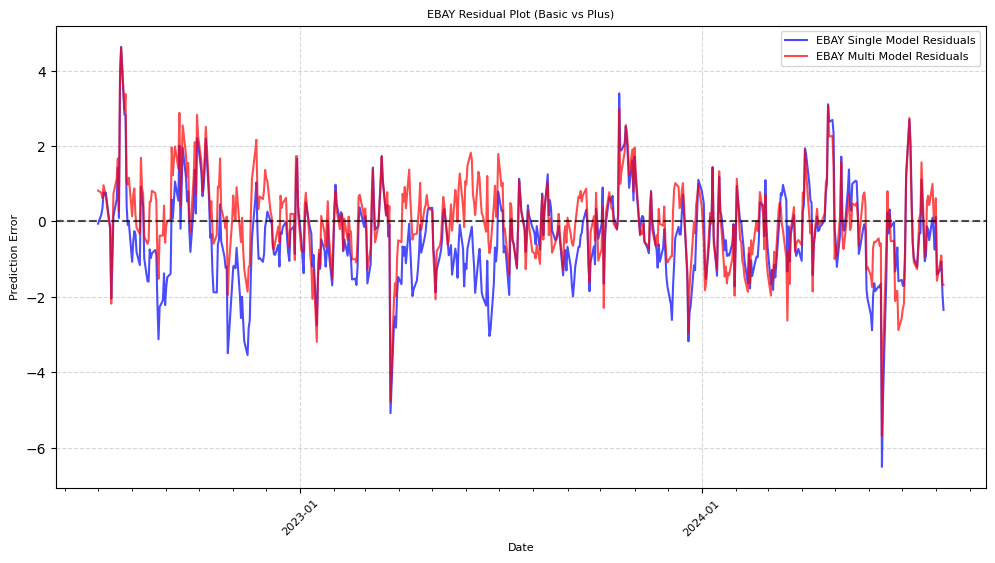

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===== EBAY 잔차 그래프 =====
plt.figure(figsize=(12, 6))
plt.plot(test_dates_ebay, y_test_rescaled_ebay_plus - y_pred_rescaled_ebay_basic,
         label='EBAY Single Model Residuals', color='blue', alpha=0.7)
plt.plot(test_dates_ebay, y_test_rescaled_ebay_plus - y_pred_rescaled_ebay_plus,
         label='EBAY Multi Model Residuals', color='red', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, fontname='Times New Roman', fontsize=8)

plt.title('EBAY Residual Plot (Basic vs Plus)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Prediction Error', fontsize=8, fontname='Times New Roman')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<ipython-input-35-06882eb9bfb2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)



### EBAY Evaluation Comparison ###
                      Model      RMSE       MAE      MAPE  Accuracy
0             Basic (Close)  1.273575  0.969608  2.091086  0.484517
1  Plus (OHLCV + Sentiment)  1.114227  0.839111  1.784004  0.500911


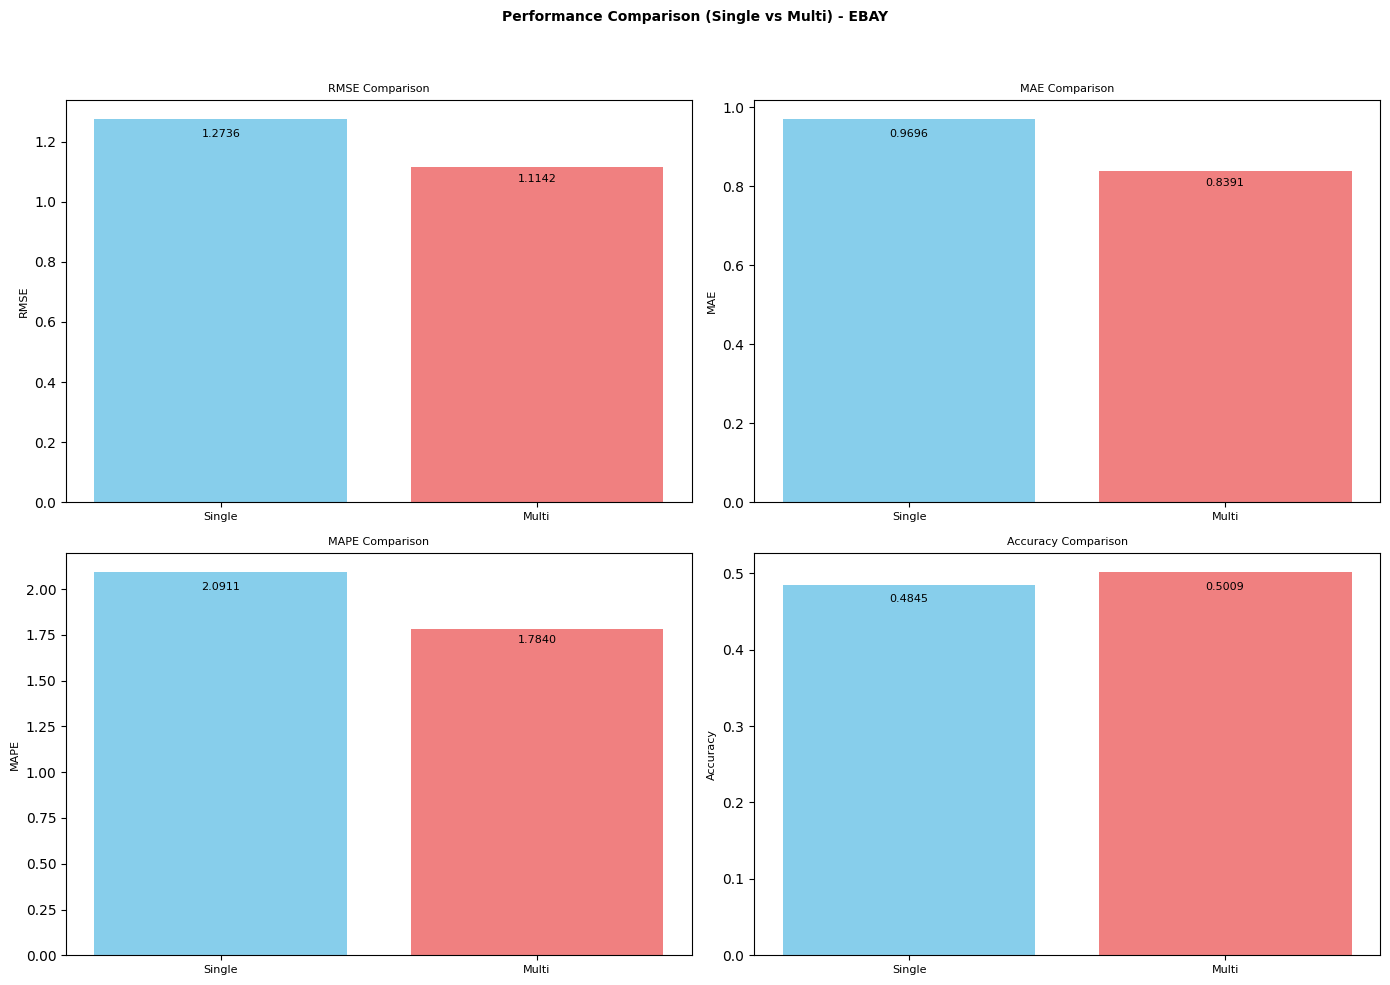

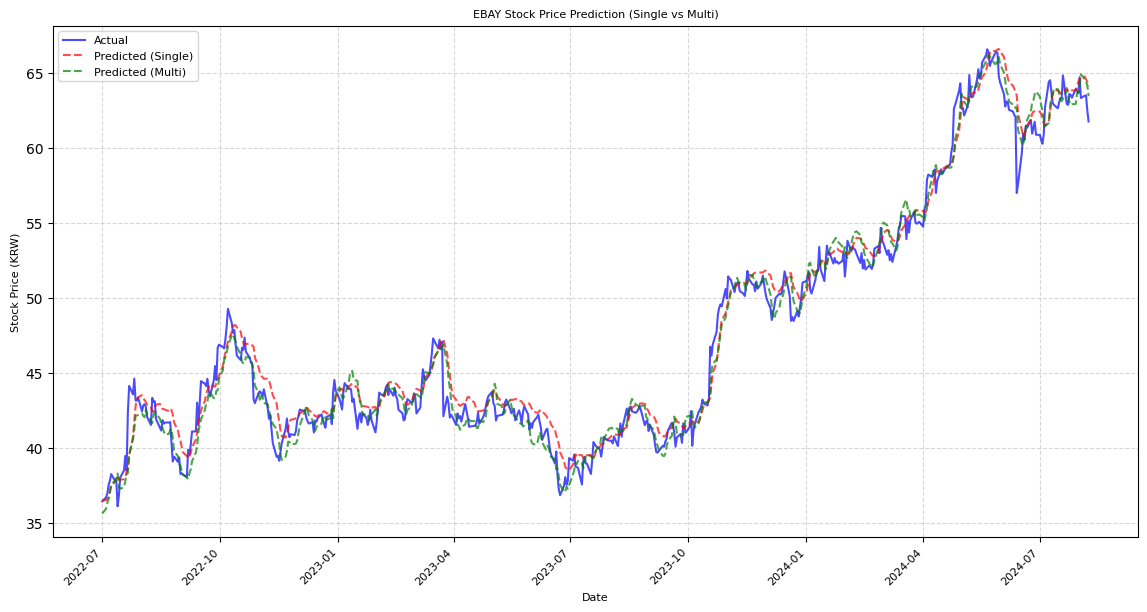

<ipython-input-35-06882eb9bfb2>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
<ipython-input-35-06882eb9bfb2>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)


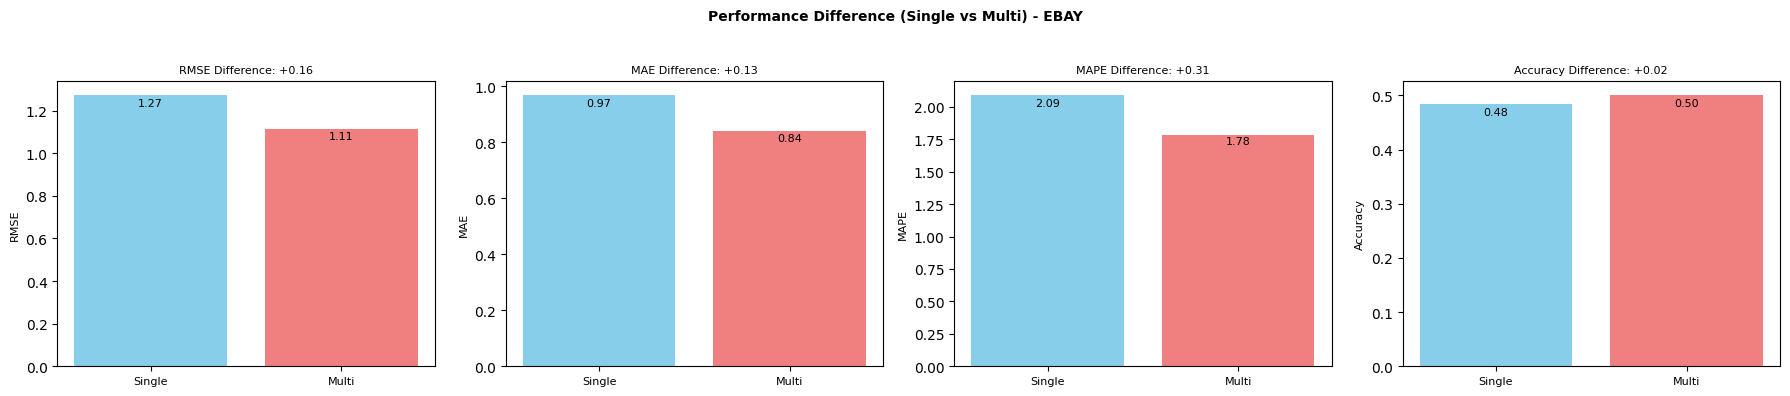

In [35]:
# ===== 성능 비교 표 출력 =====
results_ebay = pd.DataFrame({
    'Model': ['Basic (Close)', 'Plus (OHLCV + Sentiment)'],
    'RMSE': [rmse_ebay_basic, rmse_ebay_plus],
    'MAE': [mae_ebay_basic, mae_ebay_plus],
    'MAPE': [mape_ebay_basic, mape_ebay_plus],
    'Accuracy': [accuracy_ebay_basic, accuracy_ebay_plus]
})
print("\n### EBAY Evaluation Comparison ###")
print(results_ebay)

# ===== 성능 비교 바 그래프 =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['RMSE', 'MAE', 'MAPE', 'Accuracy']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(['Single', 'Multi'],
           [results_ebay.loc[0, metric], results_ebay.loc[1, metric]], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=8, fontname='Times New Roman')
    ax.set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax.set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
    for j, value in enumerate([results_ebay.loc[0, metric], results_ebay.loc[1, metric]]):
        ax.text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Comparison (Single vs Multi) - EBAY', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ===== 실제 vs 예측 주가 그래프 =====
date_index_ebay = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data_ebay_plus.index = date_index_ebay[:len(scaled_data_ebay_plus)]
predicted_index_ebay = scaled_data_ebay_plus.index[-len(y_test_rescaled_ebay_plus):]

plt.figure(figsize=(14, 7))
plt.plot(predicted_index_ebay, y_test_rescaled_ebay_plus, label='Actual', color='blue', alpha=0.7)
plt.plot(predicted_index_ebay, y_pred_rescaled_ebay_basic, label='Predicted (Single)', color='red', linestyle='--', alpha=0.7)
plt.plot(predicted_index_ebay, y_pred_rescaled_ebay_plus, label='Predicted (Multi)', color='green', linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right', fontname='Times New Roman', fontsize=8)

plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.title('EBAY Stock Price Prediction (Single vs Multi)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Stock Price (KRW)', fontsize=8, fontname='Times New Roman')
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.15)
plt.show()

# ===== 성능 차이 강조 그래프 =====
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
for i, metric in enumerate(metrics):
    if metric == 'Accuracy':
        diff = results_ebay.loc[1, metric] - results_ebay.loc[0, metric]
    else:
        diff = results_ebay.loc[0, metric] - results_ebay.loc[1, metric]
    sign = '+' if diff > 0 else '-'
    display_diff = f'{sign}{abs(diff):.2f}'

    ax[i].bar(['Single', 'Multi'],
              [results_ebay.loc[0, metric], results_ebay.loc[1, metric]],
              color=colors)
    ax[i].set_title(f'{metric} Difference: {display_diff}', fontsize=8, fontname='Times New Roman')
    ax[i].set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax[i].set_xticklabels(['Single', 'Multi'], fontname='Times New Roman', fontsize=8)
    for j, value in enumerate([results_ebay.loc[0, metric], results_ebay.loc[1, metric]]):
        ax[i].text(j, value * 0.95, f'{value:.2f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Difference (Single vs Multi) - EBAY', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# aapl

In [36]:
# 주식 데이터 불러오기 (Open, High, Low, Close, Volume)
ticker = 'AAPL'
data_aapl = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]

# 열 이름에서 종목명 제거
data_aapl.columns = data_aapl.columns.get_level_values(0)

# 정규화 수행
scalers_aapl = {}
scaled_data_aapl = pd.DataFrame(index=data_aapl.index, columns=data_aapl.columns)
for col in data_aapl.columns:
    scaler = MinMaxScaler()
    scaled_data_aapl[col] = scaler.fit_transform(data_aapl[[col]]).flatten()
    scalers_aapl[col] = scaler

# 롤링 윈도우 생성 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])  # Close 값 예측
    return np.array(X), np.array(y)

# 파라미터 설정
time_step = 20
batch_size = 32
epochs = 20

# 입력 피처: Open, High, Low, Close, Volume 사용
X_aapl_basic, y_aapl_basic = create_rolling_window(scaled_data_aapl, time_step)
split = int(len(X_aapl_basic) * 0.8)
X_train_aapl_basic, X_test_aapl_basic = X_aapl_basic[:split], X_aapl_basic[split:]
y_train_aapl_basic, y_test_aapl_basic = y_aapl_basic[:split], y_aapl_basic[split:]

# Bi-LSTM 모델 구축
aapl_basic_model = Sequential([
    Input(shape=(time_step, 5)),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

aapl_basic_model.compile(optimizer=Adam(), loss=Huber())

# 모델 학습
aapl_basic_model.fit(X_train_aapl_basic, y_train_aapl_basic, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측 수행
y_pred_aapl_basic = aapl_basic_model.predict(X_test_aapl_basic)

# 역정규화
y_test_rescaled_aapl_basic = scalers_aapl['Close'].inverse_transform(y_test_aapl_basic.reshape(-1, 1)).flatten()
y_pred_rescaled_aapl_basic = scalers_aapl['Close'].inverse_transform(y_pred_aapl_basic).flatten()

# 성능 평가
rmse_aapl_basic = np.sqrt(mean_squared_error(y_test_rescaled_aapl_basic, y_pred_rescaled_aapl_basic))
mae_aapl_basic = mean_absolute_error(y_test_rescaled_aapl_basic, y_pred_rescaled_aapl_basic)
mape_aapl_basic = np.mean(np.abs((y_test_rescaled_aapl_basic - y_pred_rescaled_aapl_basic) / y_test_rescaled_aapl_basic)) * 100

# 방향성 기반 정확도 계산
accuracy_aapl_basic = accuracy_score(
    (np.diff(y_test_rescaled_aapl_basic) > 0).astype(int),
    (np.diff(y_pred_rescaled_aapl_basic) > 0).astype(int)
)

# 결과 출력
print(f"AAPL Bi-LSTM Model RMSE: {rmse_aapl_basic:.4f}")
print(f"AAPL Bi-LSTM Model MAE: {mae_aapl_basic:.4f}")
print(f"AAPL Bi-LSTM Model MAPE: {mape_aapl_basic:.4f}%")
print(f"AAPL Bi-LSTM Model Accuracy: {accuracy_aapl_basic:.4f}")

[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
AAPL Bi-LSTM Model RMSE: 16.3518
AAPL Bi-LSTM Model MAE: 14.7349
AAPL Bi-LSTM Model MAPE: 7.6866%
AAPL Bi-LSTM Model Accuracy: 0.5301


In [41]:
# 주가 데이터
ticker = 'AAPL'
data_aapl = yf.download(ticker, start='2014-01-01', end='2024-12-31')[['Open', 'High', 'Low', 'Close', 'Volume']]
data_aapl = data_aapl.reset_index()

# 열 이름 정리
data_aapl.columns = data_aapl.columns.get_level_values(0)

# 감정 점수 불러오기
sentiment_aapl = pd.read_csv('/content/drive/MyDrive/[BDA]/국제학술제/OHLCV V.S OHLCV + SENTIMENT/최종/그냥/AAPL_merged_sentiment.csv')
sentiment_aapl['date'] = pd.to_datetime(sentiment_aapl['date'])
sentiment_aapl = sentiment_aapl.rename(columns={'date': 'Date'})

# 병합
merged_aapl = pd.merge(data_aapl, sentiment_aapl, on='Date', how='left')

# 결측치 보간
merged_aapl[['score_news', 'score_weekly']] = merged_aapl[['sentiment_mean', 'score_weekly']].ffill().bfill()

# 기술적 지표 계산
merged_aapl_ta = merged_aapl.copy()
close_series = merged_aapl_ta['Close']
merged_aapl_ta['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
merged_aapl_ta['MACD_diff'] = ta.trend.MACD(close=close_series).macd_diff()
merged_aapl_ta['BBP'] = ta.volatility.BollingerBands(close=close_series).bollinger_pband()

# VIX 불러오기
vix = yf.download('^VIX', start='2014-01-01', end='2024-12-31')[['Close']]
vix.columns = vix.columns.get_level_values(0)
vix = vix.rename(columns={'Close': 'VIX'}).reset_index()
vix['Date'] = pd.to_datetime(vix['Date'])

# VIX 병합 및 결측치 보간
merged_aapl_ta = pd.merge(merged_aapl_ta, vix[['Date', 'VIX']], on='Date', how='left')
merged_aapl_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']] = merged_aapl_ta[['RSI', 'MACD_diff', 'BBP', 'VIX']].ffill().bfill()

# 피처 목록
aapl_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_mean', 'score_weekly',
                 'RSI', 'MACD_diff', 'BBP', 'VIX']

# 정규화
scaled_data_aapl_plus = pd.DataFrame(index=merged_aapl_ta.index)
scalers_aapl_plus = {}

for col in aapl_features:
    scaler = MinMaxScaler()
    scaled_data_aapl_plus[col] = scaler.fit_transform(merged_aapl_ta[[col]]).flatten()
    scalers_aapl_plus[col] = scaler

# 롤링 윈도우 함수
def create_rolling_window(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step]['Close'])
    return np.array(X), np.array(y)

# 파라미터
time_step = 20
batch_size = 32
epochs = 20

# 데이터 생성
X_aapl_plus, y_aapl_plus = create_rolling_window(scaled_data_aapl_plus, time_step)
split = int(len(X_aapl_plus) * 0.8)
X_train_aapl_plus, X_test_aapl_plus = X_aapl_plus[:split], X_aapl_plus[split:]
y_train_aapl_plus, y_test_aapl_plus = y_aapl_plus[:split], y_aapl_plus[split:]

# Bi-LSTM 모델 정의
aapl_plus_model = Sequential([
    Input(shape=(time_step, len(aapl_features))),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
    Dropout(0.2),
    Dense(1)
])

# 학습
aapl_plus_model.compile(optimizer=Adam(), loss=Huber())
aapl_plus_model.fit(X_train_aapl_plus, y_train_aapl_plus, epochs=epochs, batch_size=batch_size, verbose=0)

# 예측
y_pred_aapl_plus = aapl_plus_model.predict(X_test_aapl_plus)

# 역정규화
y_test_rescaled_aapl_plus = scalers_aapl_plus['Close'].inverse_transform(y_test_aapl_plus.reshape(-1, 1)).flatten()
y_pred_rescaled_aapl_plus = scalers_aapl_plus['Close'].inverse_transform(y_pred_aapl_plus).flatten()

# 성능 평가
rmse_aapl_plus = np.sqrt(mean_squared_error(y_test_rescaled_aapl_plus, y_pred_rescaled_aapl_plus))
mae_aapl_plus = mean_absolute_error(y_test_rescaled_aapl_plus, y_pred_rescaled_aapl_plus)
mape_aapl_plus = np.mean(np.abs((y_test_rescaled_aapl_plus - y_pred_rescaled_aapl_plus) / y_test_rescaled_aapl_plus)) * 100
accuracy_aapl_plus = accuracy_score(
    (np.diff(y_test_rescaled_aapl_plus) > 0).astype(int),
    (np.diff(y_pred_rescaled_aapl_plus) > 0).astype(int)
)

# 결과 출력
print(f"\nAAPL Plus Model RMSE: {rmse_aapl_plus:.4f}")
print(f"AAPL Plus Model MAE: {mae_aapl_plus:.4f}")
print(f"AAPL Plus Model MAPE: {mape_aapl_plus:.4f}%")
print(f"AAPL Plus Model Accuracy: {accuracy_aapl_plus:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

AAPL Plus Model RMSE: 6.1013
AAPL Plus Model MAE: 5.0747
AAPL Plus Model MAPE: 2.9074%
AAPL Plus Model Accuracy: 0.5191


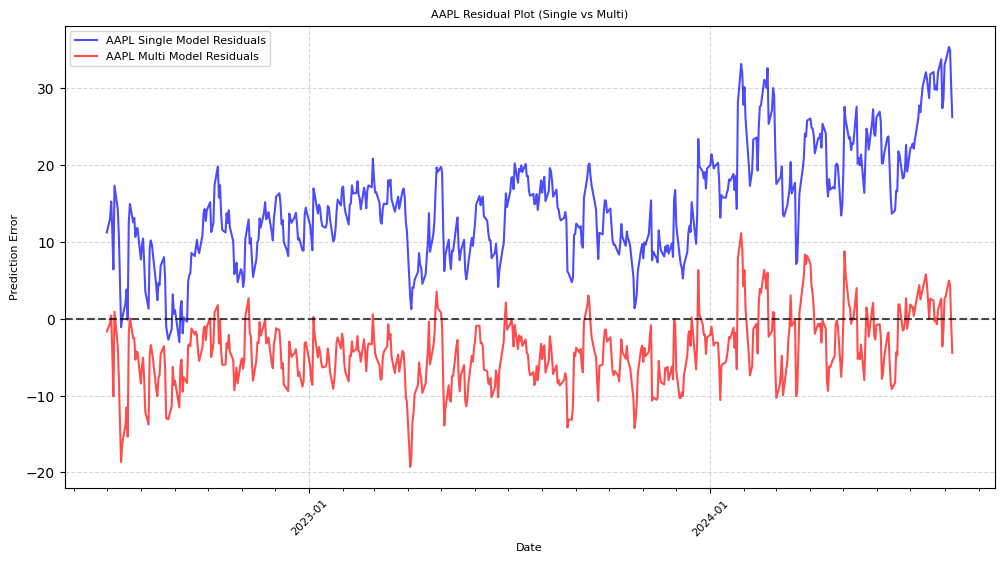

In [44]:
# ===== 성능 지표 저장 =====
results_aapl = {
    'RMSE': [rmse_aapl_basic, rmse_aapl_plus],
    'MAE': [mae_aapl_basic, mae_aapl_plus],
    'MAPE': [mape_aapl_basic, mape_aapl_plus],
    'Accuracy': [accuracy_aapl_basic, accuracy_aapl_plus]
}
results_df_aapl = pd.DataFrame(results_aapl, index=['Basic Model', 'Plus Model'])

# ===== 날짜 인덱스 생성 및 할당 =====
date_index_aapl = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data_aapl_plus.index = date_index_aapl[:len(scaled_data_aapl_plus)]

# ===== 테스트 데이터 구간 날짜 인덱스 =====
test_dates_aapl = scaled_data_aapl_plus.index[-len(y_test_rescaled_aapl_plus):]

# ===== 잔차 그래프 =====
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Basic 모델 잔차
plt.plot(test_dates_aapl, y_test_rescaled_aapl_plus - y_pred_rescaled_aapl_basic,
         label='AAPL Single Model Residuals', color='blue', alpha=0.7)

# Plus 모델 잔차
plt.plot(test_dates_aapl, y_test_rescaled_aapl_plus - y_pred_rescaled_aapl_plus,
         label='AAPL Multi Model Residuals', color='red', alpha=0.7)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, fontname='Times New Roman', fontsize=8)

# 그래프 설정
plt.title('AAPL Residual Plot (Single vs Multi)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Prediction Error', fontsize=8, fontname='Times New Roman')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend(prop={'family': 'Times New Roman', 'size': 8})

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### AAPL Evaluation Comparison ###
                      Model      RMSE        MAE      MAPE  Accuracy
0             Basic (Close)  16.35181  14.734854  7.686580  0.530055
1  Plus (OHLCV + Sentiment)   6.10134   5.074720  2.907353  0.519126


<ipython-input-46-507e339cf0b0>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Basic (Close)', 'Plus (OHLCV + Sentiment)'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Basic (Close)', 'Plus (OHLCV + Sentiment)'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Basic (Close)', 'Plus (OHLCV + Sentiment)'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

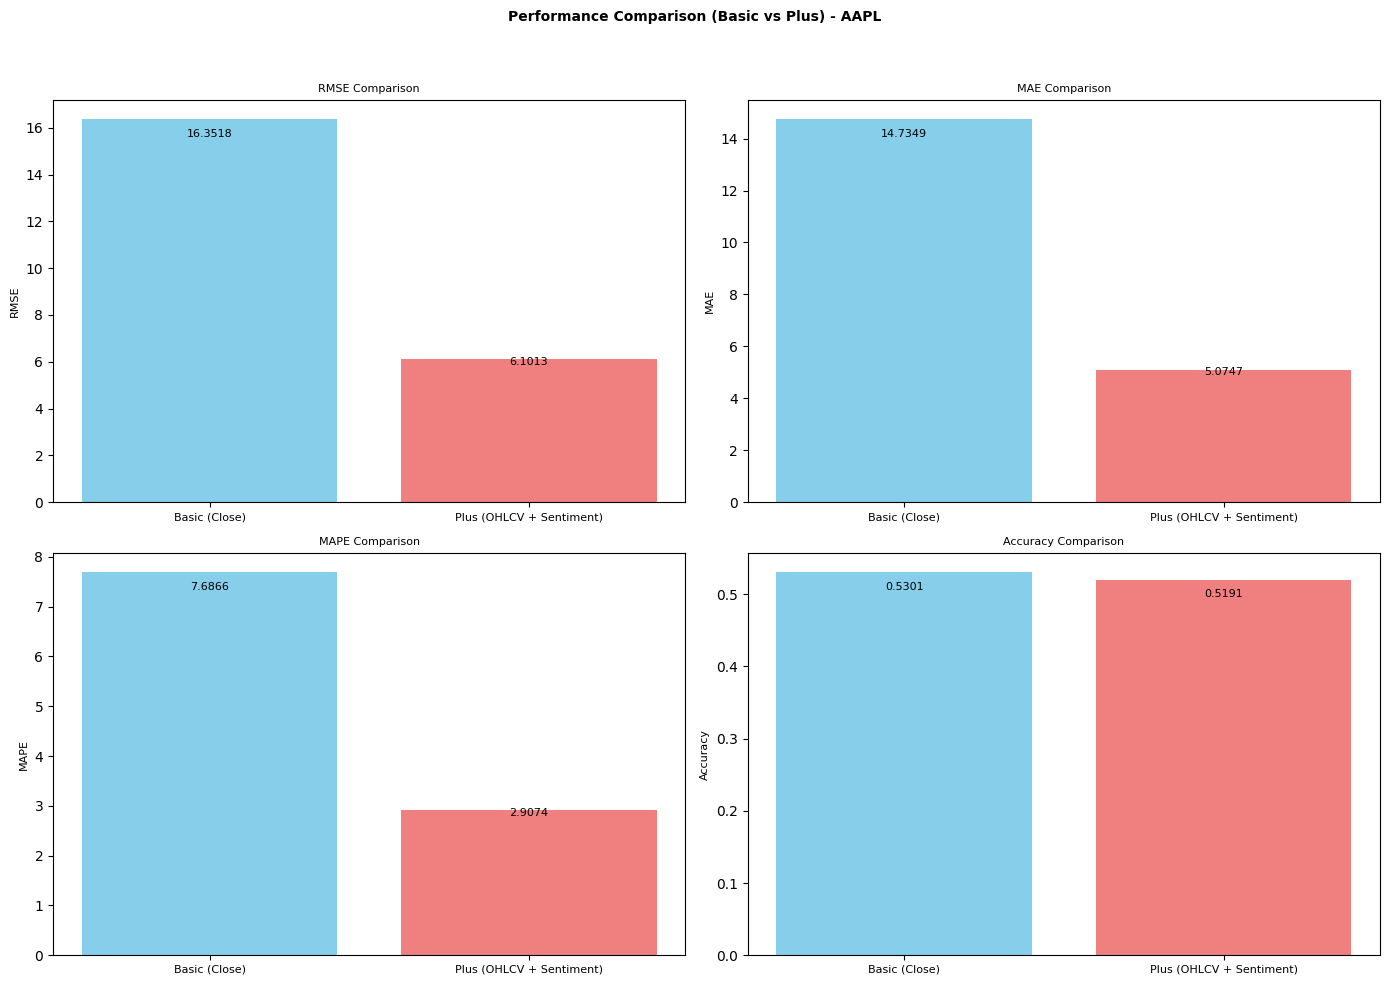

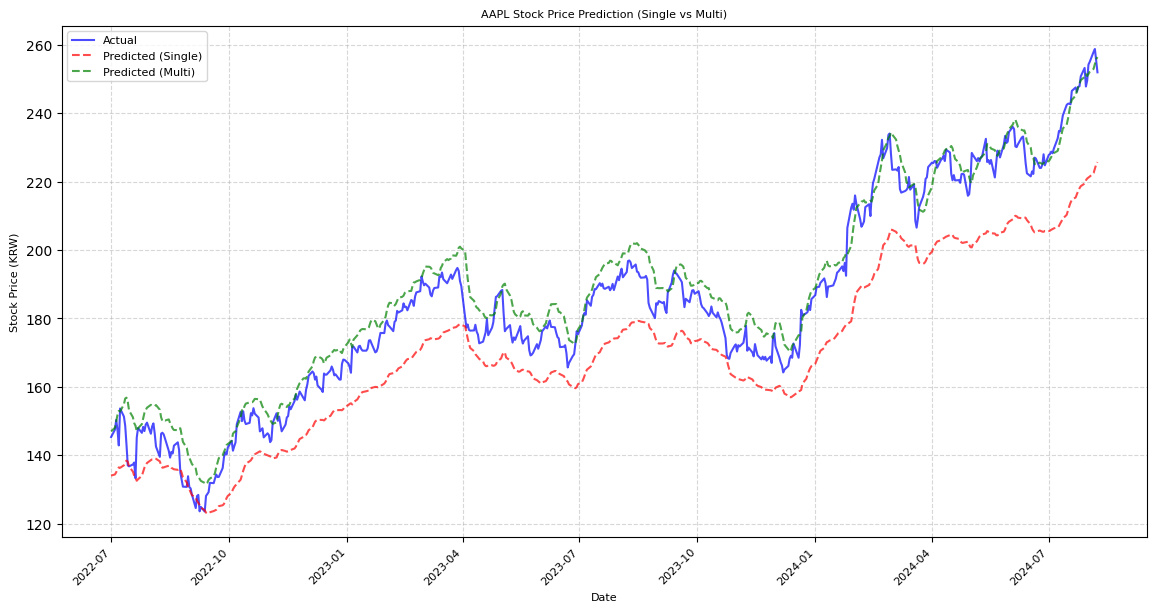

<ipython-input-46-507e339cf0b0>:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Basic', 'Plus'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Basic', 'Plus'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Basic', 'Plus'], fontname='Times New Roman', fontsize=8)
<ipython-input-46-507e339cf0b0>:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Basic', 'Plus'], fontname='Times New Roman', fontsize=8)


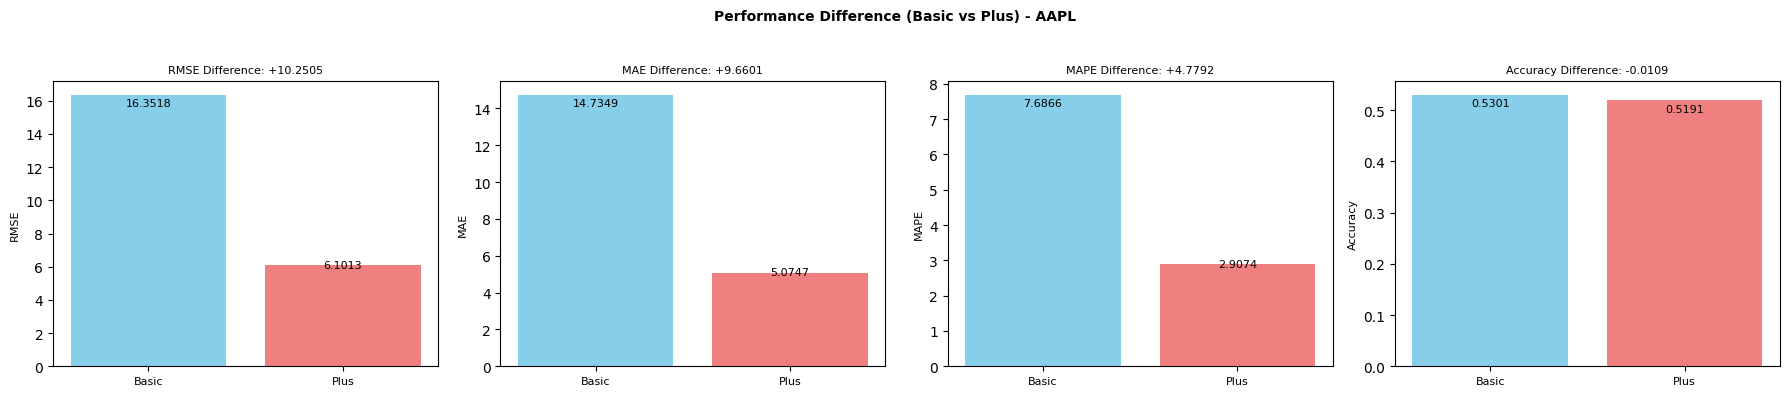

In [46]:
# ===== 성능 비교 표 출력 =====
results_aapl = pd.DataFrame({
    'Model': ['Basic (Close)', 'Plus (OHLCV + Sentiment)'],
    'RMSE': [rmse_aapl_basic, rmse_aapl_plus],
    'MAE': [mae_aapl_basic, mae_aapl_plus],
    'MAPE': [mape_aapl_basic, mape_aapl_plus],
    'Accuracy': [accuracy_aapl_basic, accuracy_aapl_plus]
})

print("\n### AAPL Evaluation Comparison ###")
print(results_aapl)

# ===== 성능 비교 바 그래프 =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['RMSE', 'MAE', 'MAPE', 'Accuracy']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(['Basic (Close)', 'Plus (OHLCV + Sentiment)'],
           [results_aapl.loc[0, metric], results_aapl.loc[1, metric]],
           color=colors)

    ax.set_title(f'{metric} Comparison', fontsize=8, fontname='Times New Roman')
    ax.set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax.set_xticklabels(['Basic (Close)', 'Plus (OHLCV + Sentiment)'], fontname='Times New Roman', fontsize=8)

    for j, value in enumerate([results_aapl.loc[0, metric], results_aapl.loc[1, metric]]):
        ax.text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Comparison (Basic vs Plus) - AAPL', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ===== 실제 vs 예측 주가 비교 그래프 =====
date_index_aapl = pd.date_range(start='2014-01-01', end='2024-12-31', freq='B')
scaled_data_aapl_plus.index = date_index_aapl[:len(scaled_data_aapl_plus)]
predicted_index_aapl = scaled_data_aapl_plus.index[-len(y_test_rescaled_aapl_plus):]

plt.figure(figsize=(14, 7))

# 실제 주가
plt.plot(predicted_index_aapl, y_test_rescaled_aapl_plus, label='Actual', color='blue', alpha=0.7)

# Basic 모델 예측 주가
plt.plot(predicted_index_aapl, y_pred_rescaled_aapl_basic, label='Predicted (Single)', color='red', linestyle='--', alpha=0.7)

# Plus 모델 예측 주가
plt.plot(predicted_index_aapl, y_pred_rescaled_aapl_plus, label='Predicted (Multi)', color='green', linestyle='--', alpha=0.7)

# 날짜 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right', fontname='Times New Roman', fontsize=8)

plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.title('AAPL Stock Price Prediction (Single vs Multi)', fontsize=8, fontname='Times New Roman')
plt.xlabel('Date', fontsize=8, fontname='Times New Roman')
plt.ylabel('Stock Price (KRW)', fontsize=8, fontname='Times New Roman')
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplots_adjust(bottom=0.15)
plt.show()

# ===== 성능 차이 강조 그래프 =====
fig, ax = plt.subplots(1, 4, figsize=(18, 4))

for i, metric in enumerate(metrics):
    if metric == 'Accuracy':
        diff = results_aapl.loc[1, metric] - results_aapl.loc[0, metric]
    else:
        diff = results_aapl.loc[0, metric] - results_aapl.loc[1, metric]

    sign = '+' if diff > 0 else '-'
    display_diff = f'{sign}{abs(diff):.4f}'

    ax[i].bar(['Basic', 'Plus'],
              [results_aapl.loc[0, metric], results_aapl.loc[1, metric]],
              color=colors)

    ax[i].set_title(f'{metric} Difference: {display_diff}', fontsize=8, fontname='Times New Roman')
    ax[i].set_ylabel(metric, fontsize=8, fontname='Times New Roman')
    ax[i].set_xticklabels(['Basic', 'Plus'], fontname='Times New Roman', fontsize=8)

    for j, value in enumerate([results_aapl.loc[0, metric], results_aapl.loc[1, metric]]):
        ax[i].text(j, value * 0.95, f'{value:.4f}', ha='center', va='bottom', fontsize=8, fontname='Times New Roman')

plt.suptitle('Performance Difference (Basic vs Plus) - AAPL', fontsize=10, fontweight='bold', fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


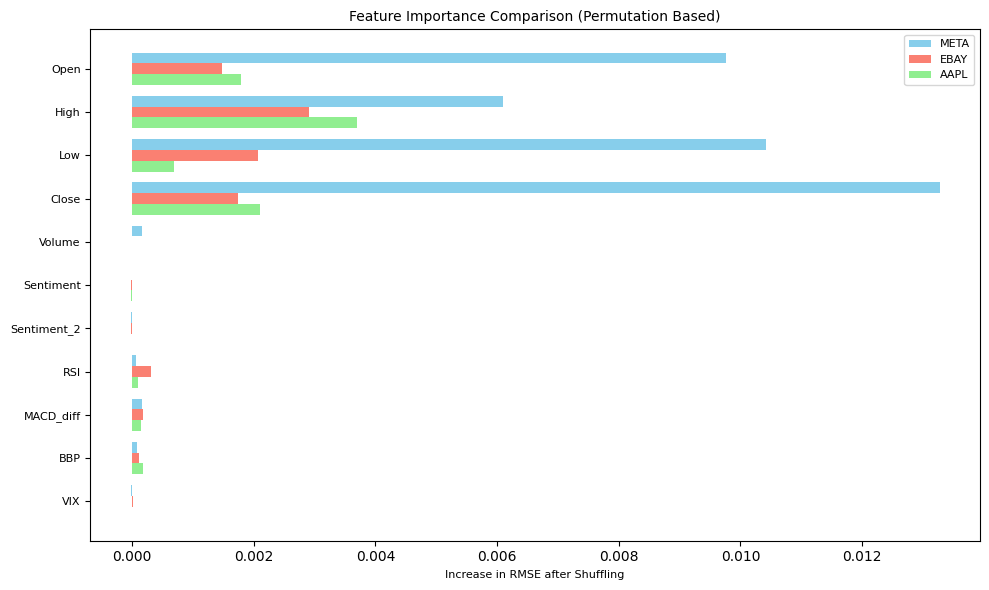

In [50]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ===== 공통 중요도 계산 함수 =====
def permutation_importance_lstm(model, X_val, y_val, feature_names, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []

    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])
        permuted_score = metric(y_val, model.predict(X_permuted))
        importances.append(permuted_score - baseline)

    return dict(zip(feature_names, importances))


# ===== 중요도 계산 =====

# Meta
feature_names_meta = ['Open', 'High', 'Low', 'Close', 'Volume', 'score_news', 'score_weekly',
                      'RSI', 'MACD_diff', 'BBP', 'VIX']
importances_meta = permutation_importance_lstm(plus_model, X_test_plus, y_test_plus, feature_names_meta)

# EBAY
feature_names_ebay = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Sentiment_Avg', 'score_weekly',
                      'RSI', 'MACD_diff', 'BBP', 'VIX']
importances_ebay = permutation_importance_lstm(ebay_plus_model, X_test_ebay_plus, y_test_ebay_plus, feature_names_ebay)

# AAPL
feature_names_aapl = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_mean', 'score_weekly',
                      'RSI', 'MACD_diff', 'BBP', 'VIX']
importances_aapl = permutation_importance_lstm(aapl_plus_model, X_test_aapl_plus, y_test_aapl_plus, feature_names_aapl)

# ===== 피처 이름 통일 =====
# 각 감정 피처 이름을 'Sentiment'로 통일
def standardize_keys(importances, original_key):
    importances_std = importances.copy()
    importances_std['Sentiment'] = importances_std.pop(original_key)
    return importances_std

importances_meta = standardize_keys(importances_meta, 'score_news')
importances_ebay = standardize_keys(importances_ebay, 'Daily_Sentiment_Avg')
importances_aapl = standardize_keys(importances_aapl, 'sentiment_mean')

# 공통 피처 순서 지정
# ===== 시각화 =====
# 표시할 피처 순서와 이름 분리 (실제 키 이름과 시각화용 이름 따로 지정)
feature_order = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'score_weekly',
                 'RSI', 'MACD_diff', 'BBP', 'VIX']
display_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment', 'Sentiment_2',
                 'RSI', 'MACD_diff', 'BBP', 'VIX']

x = np.arange(len(feature_order))
width = 0.25

plt.figure(figsize=(10, 6))

plt.barh(x - width, [importances_meta[f] for f in feature_order], height=width, label='META', color='skyblue')
plt.barh(x,         [importances_ebay[f] for f in feature_order], height=width, label='EBAY', color='salmon')
plt.barh(x + width, [importances_aapl[f] for f in feature_order], height=width, label='AAPL', color='lightgreen')

plt.yticks(x, display_names, fontname='Times New Roman', fontsize=8)
plt.xlabel("Increase in RMSE after Shuffling", fontname='Times New Roman', fontsize=8)
plt.title("Feature Importance Comparison (Permutation Based)", fontname='Times New Roman', fontsize=10)
plt.legend(prop={'family': 'Times New Roman', 'size': 8})
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 피처임포턴스 모아둔거

In [ ]:
# ebay

# EBAY Plus 모델 피처 중요도 계산 함수
def permutation_importance_lstm(model, X_val, y_val, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []

    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Sentiment_Avg', 'score_weekly',
                     'RSI', 'MACD_diff', 'BBP', 'VIX']

    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])  # i번째 feature만 섞음
        permuted_score = metric(y_val, model.predict(X_permuted))
        importances.append(permuted_score - baseline)

    return dict(zip(feature_names, importances))

# 중요도 계산
importances_ebay = permutation_importance_lstm(ebay_plus_model, X_test_ebay_plus, y_test_ebay_plus)

# 결과 출력
print("\n[EBAY] Feature Importance (Permutation 방식):")
for k, v in importances_ebay.items():
    print(f"{k:25s}: {v:.6f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(list(importances_ebay.keys()), list(importances_ebay.values()))
plt.xlabel("Increase in RMSE after Shuffling", fontname='Times New Roman', fontsize=8)
plt.title("Feature Importance - EBAY Plus Model", fontname='Times New Roman', fontsize=10)
plt.xticks(fontname='Times New Roman', fontsize=8)
plt.yticks(fontname='Times New Roman', fontsize=8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# 중요도 계산 함수 (AAPL용)
def permutation_importance_lstm(model, X_val, y_val, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_mean', 'score_weekly',
                     'RSI', 'MACD_diff', 'BBP', 'VIX']

    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, :, i])  # i번째 feature만 섞음
        permuted_score = metric(y_val, model.predict(X_permuted))
        importances.append(permuted_score - baseline)

    return dict(zip(feature_names, importances))

# 중요도 계산
importances_aapl = permutation_importance_lstm(aapl_plus_model, X_test_aapl_plus, y_test_aapl_plus)

# 결과 출력
print("\n[AAPL] Feature Importance (Permutation 방식):")
for k, v in importances_aapl.items():
    print(f"{k:25s}: {v:.6f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(list(importances_aapl.keys()), list(importances_aapl.values()))
plt.xlabel("Increase in RMSE after Shuffling", fontname='Times New Roman', fontsize=8)
plt.title("Feature Importance - AAPL Plus Model", fontname='Times New Roman', fontsize=10)
plt.xticks(fontname='Times New Roman', fontsize=8)
plt.yticks(fontname='Times New Roman', fontsize=8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()